# Vehicles consumption data, visual exploration demo

The US goverment provides a database of fuel consumption information [1] for a wide range of car makes and models. In this demo, we explore this data set visually.

See [1] for a description of the variables.

[1] http://www.fueleconomy.gov/feg/ws/index.shtml

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

In [2]:
# Load fuel consumption data.
# The data was downloaded from http://www.fueleconomy.gov/feg/ws/index.shtml
filename = 'vehicles.csv'
vehicles = pd.read_csv(filename, engine='python')

In [3]:
# Clean up the data: only electric vehicles have ranges, and there are a few zero ranges that we mark as missing data.
vehicles.ix[vehicles.range <= 0, 'range'] = np.nan
vehicles.ix[vehicles.rangeCity <= 0, 'rangeCity'] = np.nan
vehicles.ix[vehicles.rangeHwy <= 0, 'rangeHwy'] = np.nan

Basic Plots With Pandas
-----------------------

One of the most interesting variables is `comb08`, which is a combined measure of MPG consumption. Let's have a look at its distribution.

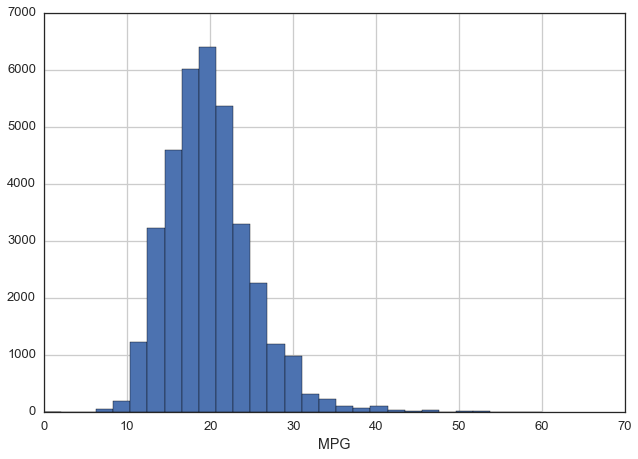

In [4]:
vehicles.comb08.hist(bins=np.linspace(0,60,30))
plt.xlabel('MPG');

We can also look at the distribution of multiple variables:

```
comb08: combined MPG for fuelType1
range: range for fuelType1
barrels08: annual petroleum consumption in barrels for fuelType1
displ: engine displacement in liters
```

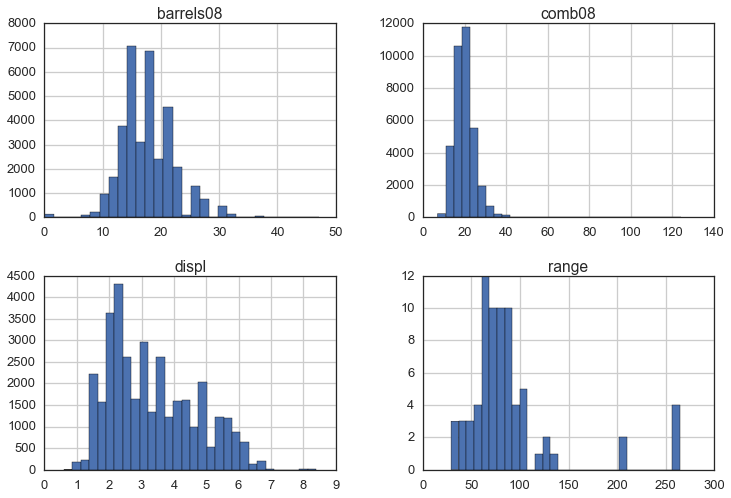

In [5]:
vehicles.hist(column=['comb08', 'range', 'barrels08', 'displ'], bins=30, figsize=(12, 8));

More information can be gained by looking at the joint distribution of pairs of variables.

For instance, as might be expected, consumption worsens for engine with larger displacement.

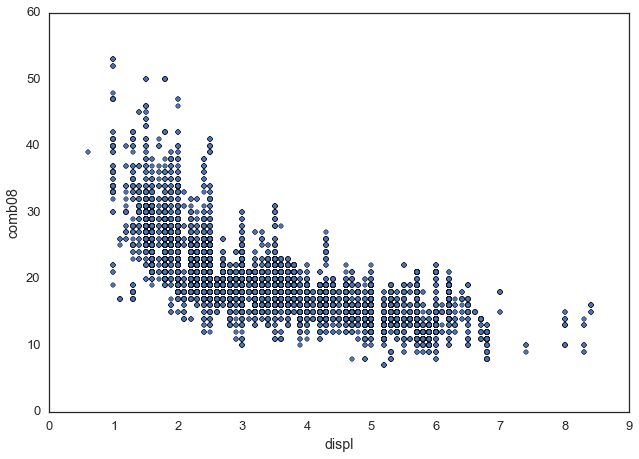

In [6]:
vehicles.plot(x='displ', y='comb08', kind='scatter');

Does consumption improve with time? We can visualize that as the joint distribution of `year` and `comb08`.

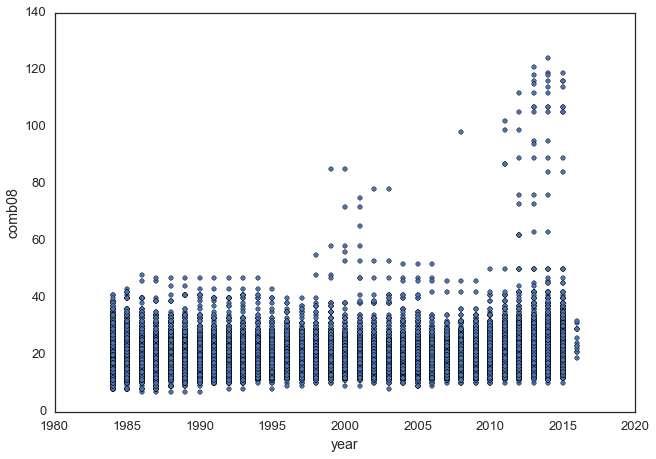

In [7]:
vehicles.plot(x='year', y='comb08', kind='scatter');

More Complex Plots with Seaborn
-------------------------------

The Seaborn ploting library sits on top of Pandas and Matplotlib and allows easy generation of some standard plot types.

A `jointplot` can display the *joint* and the *marginal* distribution of two variables.

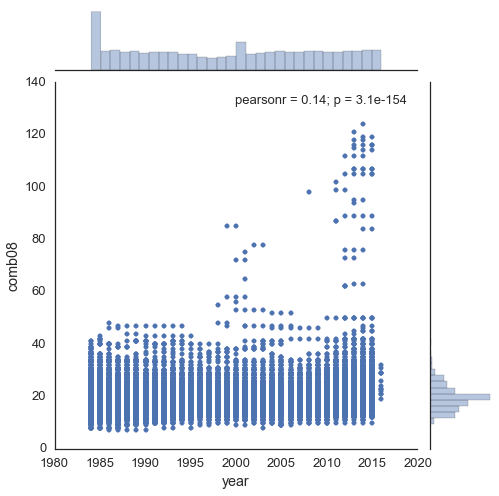

In [8]:
sns.jointplot(x="year", y="comb08", data=vehicles, size=7);

By using a `FacetGrid`, we can display the joint distribution assigning different colors according to the values in third column.

`FacetGrid` is a very flexible object, more about it later...

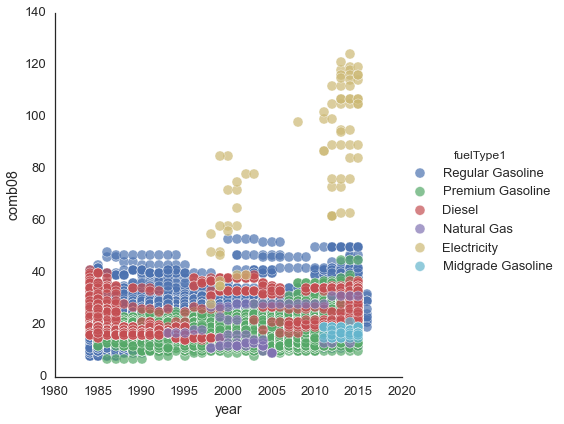

In [9]:
g = sns.FacetGrid(vehicles, hue="fuelType1", size=6)
g.map(plt.scatter, "year", "comb08", s=100, alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend()

It looks like the apparent increase in efficiency is due to the appearance of electric cars... we should have a closer look at the primary fuel type for the cars.

We can use `countplot` to get a basic breakdown of the distribution between different fuel types.

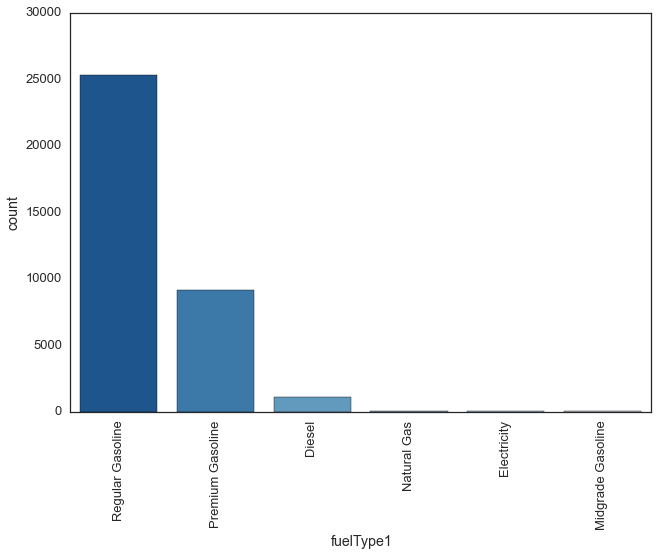

In [10]:
sns.countplot(x='fuelType1', data=vehicles, palette='Blues_r')
plt.xticks(rotation=90);

Let's see what type of drive-trains use each type of fuel.  We can get further breakdown into categories using the `hue` parameter.  

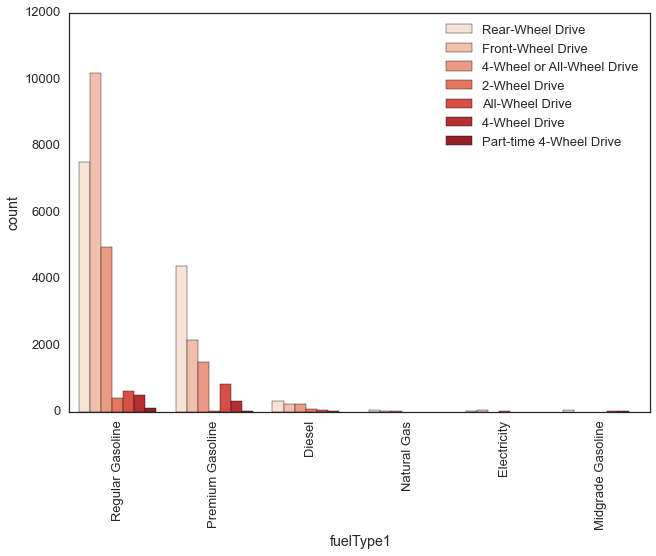

In [11]:
sns.countplot(x='fuelType1', hue='drive', data=vehicles, palette='Reds')

plt.legend(loc='upper right')
plt.xticks(rotation=90);

We can also investigate statistics other than the raw count associated with each category, using the `factorplot` command.

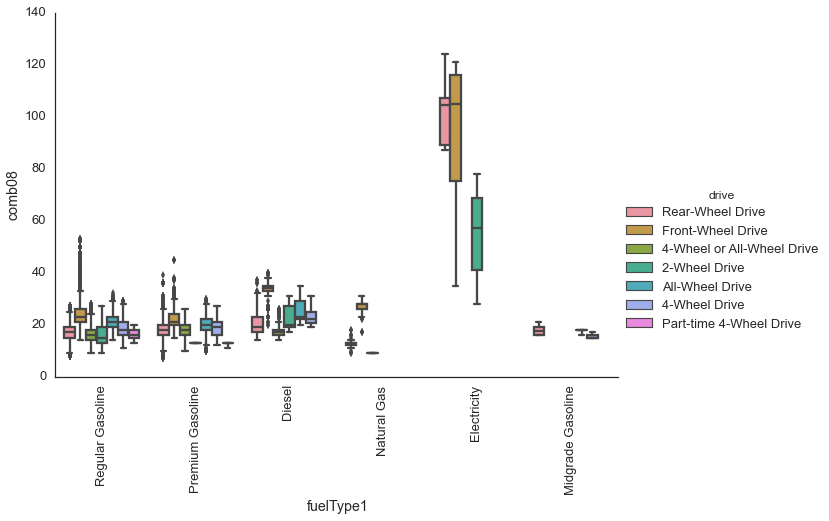

In [12]:
sns.factorplot(x='fuelType1', y='comb08', hue='drive', kind='box', data=vehicles, aspect=1.5, size=6)
plt.xticks(rotation=90);

The `factorplot` function uses the `FacetGrid` infrastructure (see below), so it can also display arrays of plots.  By breaking out `fuelType1` categories into separate plots, we can see the change in efficiency over time by different vehicle types.

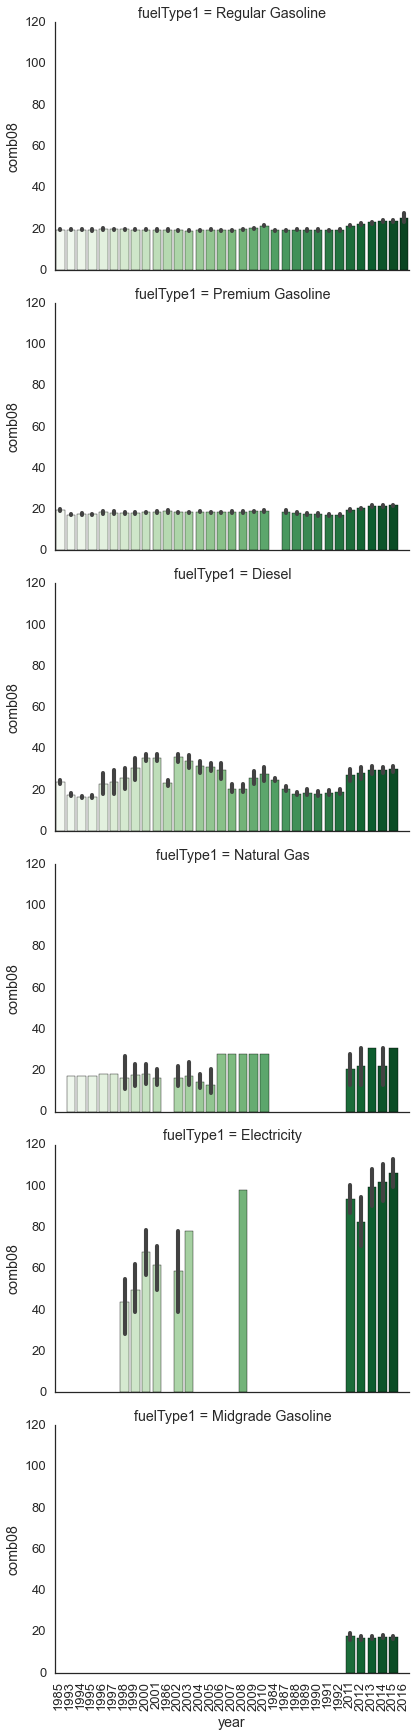

In [13]:
sns.factorplot(x='year', y='comb08', row='fuelType1', kind='bar', data=vehicles, aspect=1.5, palette='Greens')
plt.xticks(rotation=90);

`FacetGrid` can be used to create a grid of plots. Each plot in the grid will contain data grouped by the DataFrame columns corresponding to its row and column.  The exact type of plot that appears in a cell is determined by using the `map` method with a plotting function: in this case matplotlib's standard `scatter` plot.

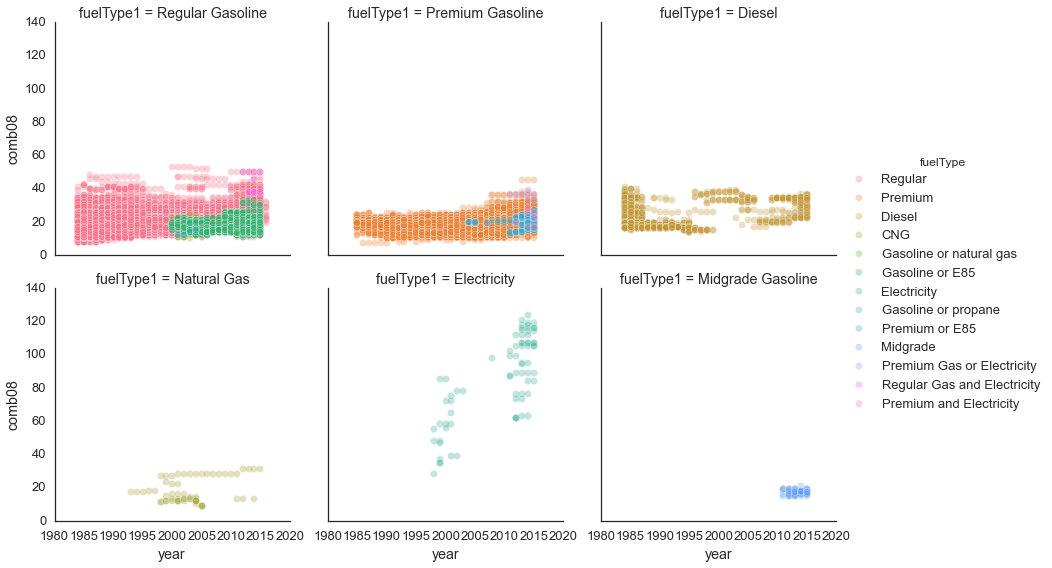

In [14]:
g = sns.FacetGrid(vehicles, col="fuelType1", hue='fuelType', col_wrap=3, size=4)
g.map(plt.scatter, "year", "comb08", s=50, alpha=.3, linewidth=.5, edgecolor="white")
g.add_legend();

Overall, the increase in efficiency over the past 35 years doesn't look very impressive. Does that depend on car make?

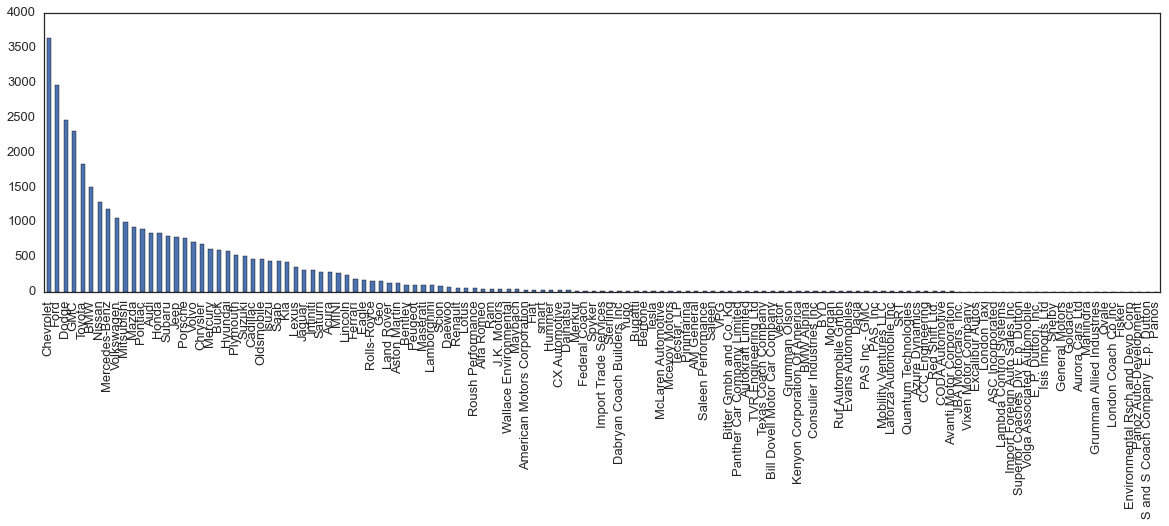

In [15]:
make_counts = pd.value_counts(vehicles.make)
make_counts.plot(kind='bar', figsize=(20, 5));

Too many makes, we may want to focus on the top ones.

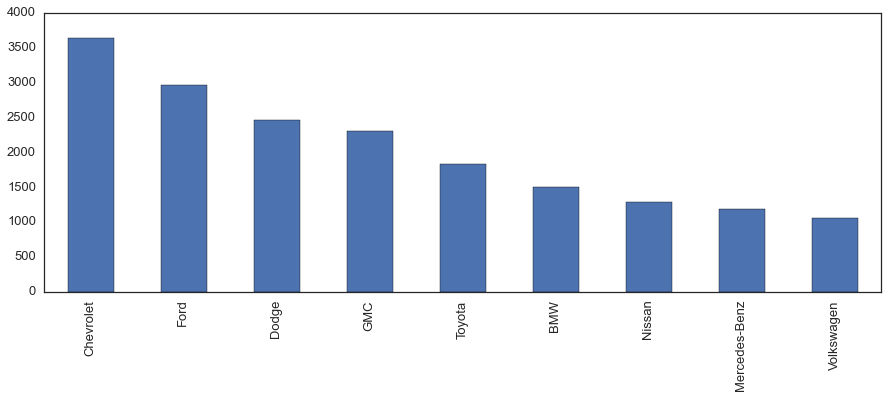

In [16]:
make_counts = make_counts[make_counts > 1000]
make_counts.plot(kind='bar', figsize=(15, 5))

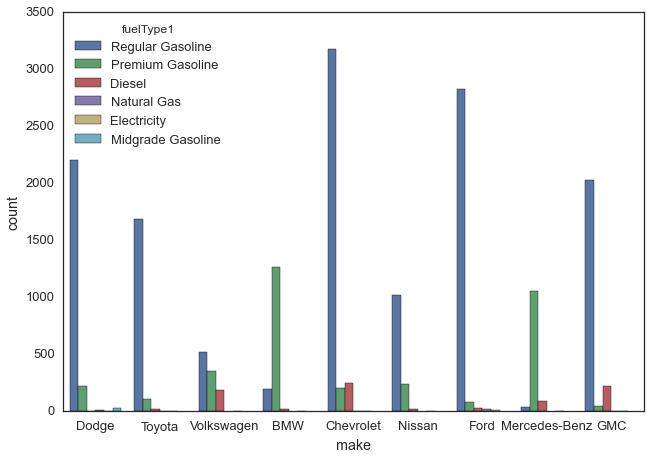

In [17]:
# Let's take a subset of the dataset which only contains the top makes:
top_make_filter = vehicles.make.map(lambda x: x in make_counts.index)
top_makes = vehicles[top_make_filter]

sns.countplot('make', data=top_makes, hue='fuelType1')

We can use `FacetGrid` once more, to show consumption as a function of time, grouped by make (rows) and number of cylinders (columns).  We're interested in the trends, so rather than a scatter plot, we use Seaborn's `regplot` to plot a scatterplot with a regression line. 

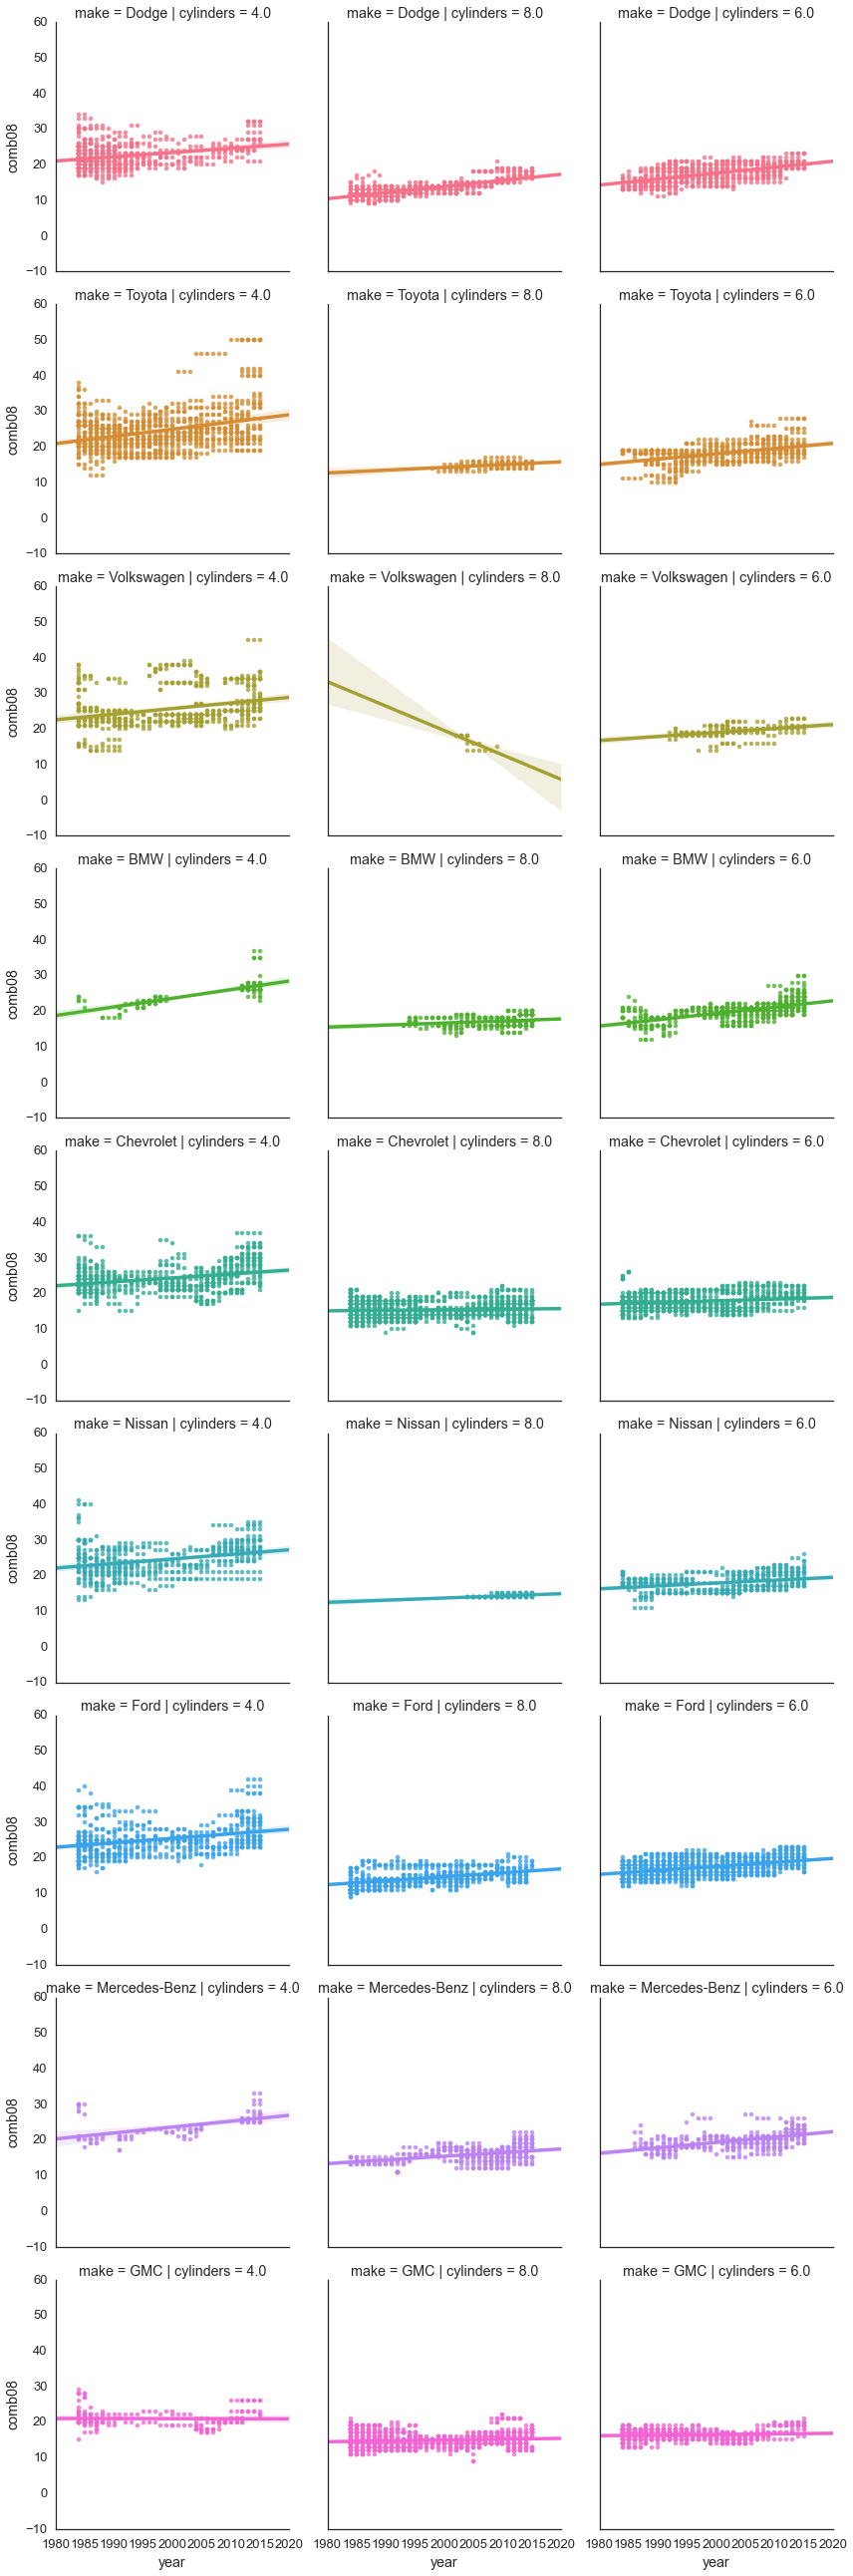

In [18]:
cylinders = [4, 6, 8]
condition = vehicles.make.map(lambda x: x in make_counts.index) & vehicles.cylinders.map(lambda x: x in cylinders)
top_makes = vehicles[condition]

g = sns.FacetGrid(top_makes, row='make', col='cylinders', hue='make', size=4)
g.map(sns.regplot, 'year', 'comb08', ci=99);

There are also plots that allow closer inspection of the distribution of the data.  For example, kernel density estimators (KDEs) are often preferable to histograms.  Seaborn provides `kdeplot` for this purpose, so we could get a smoother plot of the fuel efficiency distribution.

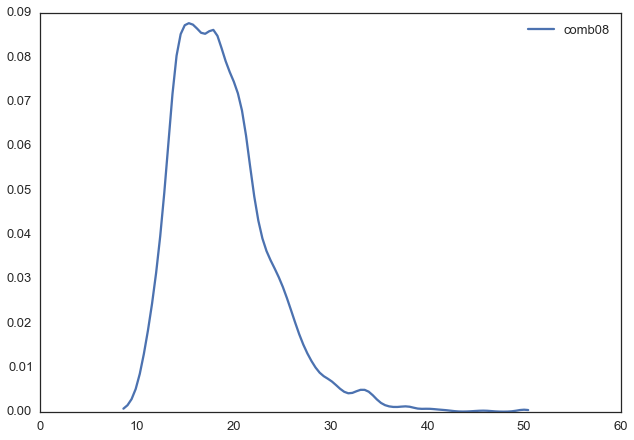

In [19]:
sns.kdeplot(top_makes.comb08)

We can also see the distribution in multiple variables using `kdeplot`.  For example, city vs. highway driving efficiency is distributed like this:

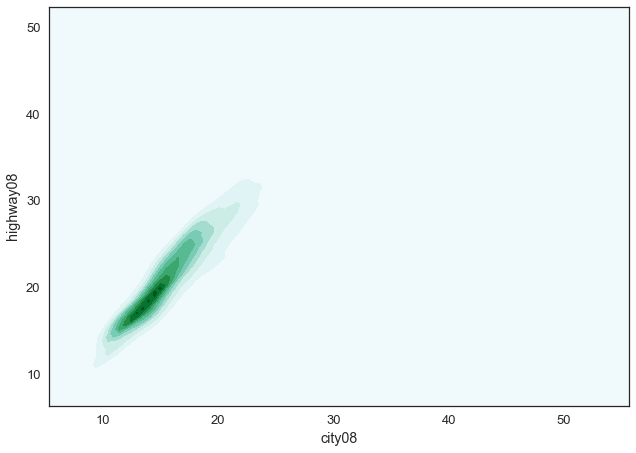

In [20]:
sns.kdeplot(top_makes.city08, top_makes.highway08, shade=True)

We can combine `kdeplot` with `FacetGrid` to break out distributions by make:

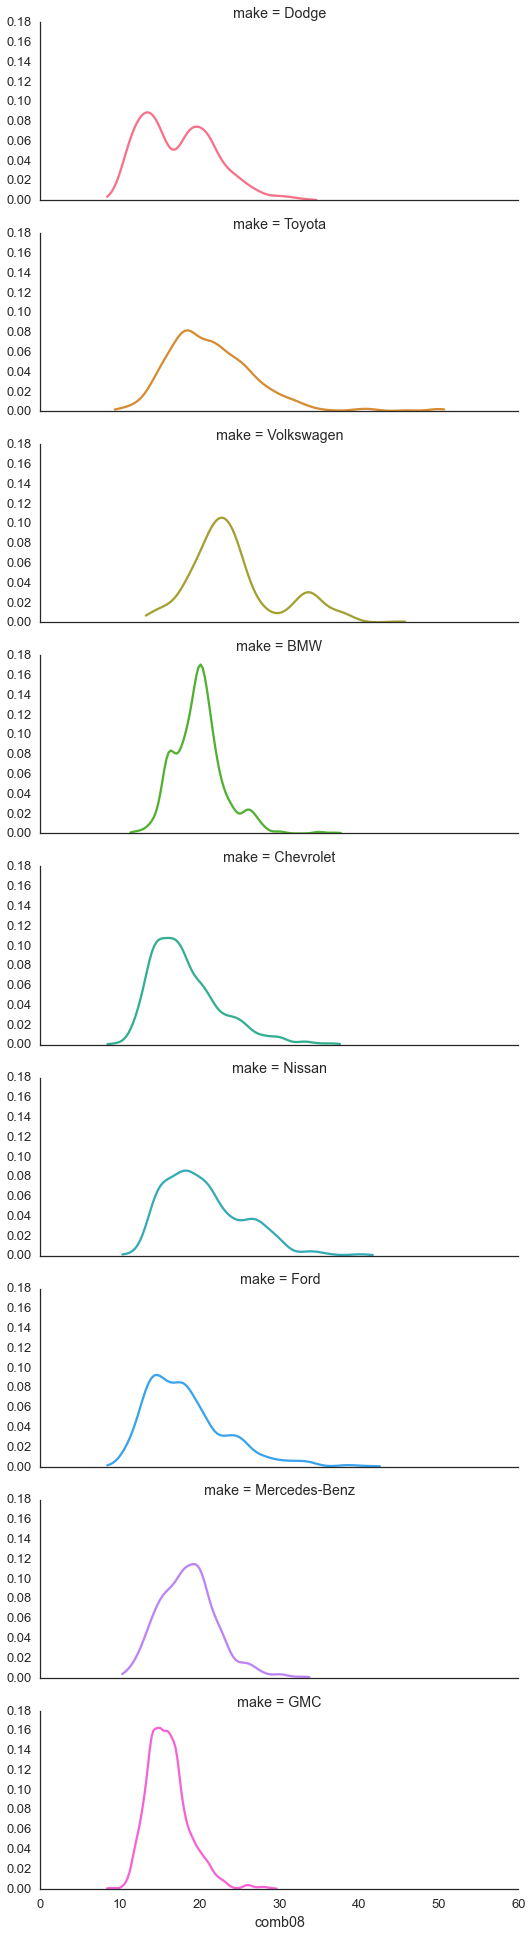

In [21]:
g = sns.FacetGrid(top_makes, row='make', hue='make', aspect=2.5)
g.map(sns.kdeplot, 'comb08');

Another, more compact, way of comparing distributions is to use a violin plot, which displays the KDE distributions vertically.

(0, 40)

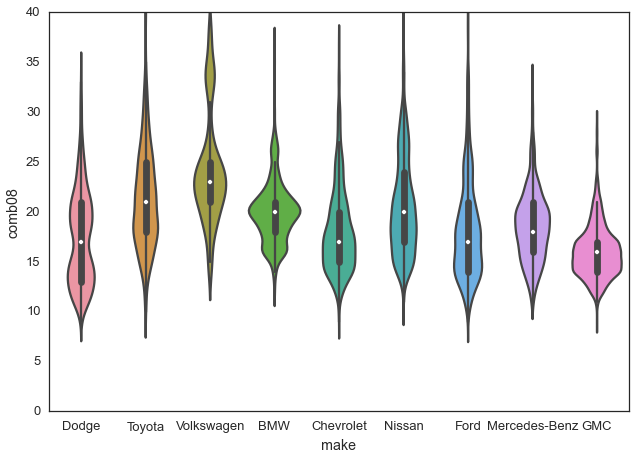

In [22]:
sns.violinplot(x='make', y='comb08', data=top_makes)
plt.ylim([0, 40])

Violin plots can also be used to compare arbitrary sequence distributions.  For example, to compare the distribution of electric vehicle ranges, you could create a data frame with the data and give it to the `violinplot` function:

(0, 300)

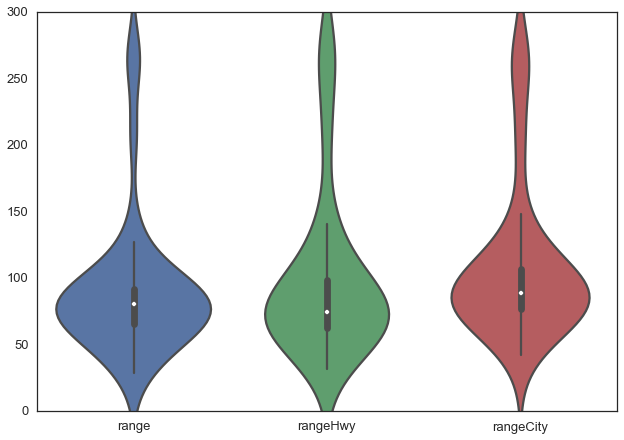

In [23]:
sns.violinplot(data=vehicles[['range', 'rangeHwy', 'rangeCity']])
plt.ylim([0, 300])